# Proyecto TT H1

## Importación y carga

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits.mplot3d import Axes3D

In [4]:
df = pd.read_csv('Online_Retail.csv', encoding='ISO-8859-1')

## Exploración del Dataset

In [6]:
# Inspeccionar y visualizar datos
df.columns = df.columns.str.lower()
display(df.info())
print("\n 'Varlores Nulos'")
display(df.isnull().sum())
print("\n 'Valores Duplicados'")
display(df.duplicated().sum())
print("\n 'Valores Duplicados'")
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   region        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None


 'Varlores Nulos'


invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
region               0
dtype: int64


 'Valores Duplicados'


5268


 'Valores Duplicados'


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2019 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2019 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2019 08:26,3.39,17850.0,United Kingdom


## Preprocesamiento de los datos

In [8]:
# Manejar valores nulos en 'customer_id'
# Vamos a eliminar las filas sin customer_id, ya que no podemos hacer segmentación sin esta información
df = df.dropna(subset=['customer_id'])

# Verificar valores nulos nuevamente
print("\n Valores nulos nuevamente")
print(df.isnull().sum())
print("\n")

# Eliminar duplicados
df = df.drop_duplicates()

# Verificar duplicados nuevamente
duplicados = df.duplicated().sum()
print(f"Número de filas duplicadas después de la eliminación: {duplicados}")


 Valores nulos nuevamente
invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
region          0
dtype: int64


Número de filas duplicadas después de la eliminación: 0


In [9]:
# Convertir 'invoice_date' a datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")

# Verificar el tipo de dato de 'invoice_date'
print(df['invoice_date'].dtype)

datetime64[ns]


In [10]:
df.describe()

,quantity,invoice_date,unit_price,customer_id
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2020-07-10 08:03:59.659963904,3.474064,15281.160818
min,-80995.000000,2019-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2020-04-06 15:02:00,1.250000,13939.000000
50%,5.000000,2020-07-29 15:40:00,1.950000,15145.000000
75%,12.000000,2020-10-20 11:58:30,3.750000,16784.000000
max,80995.000000,2020-12-09 12:50:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


In [11]:
# Eliminar registros con cantidad o precio unitario negativos
df = df[(df['quantity'] > 0) & (df['unit_price'] > 0)]

# Verificar el rango de 'quantity' y 'unit_price'
print(df[['quantity', 'unit_price']].describe())

            quantity     unit_price
count  392692.000000  392692.000000
mean       13.119702       3.125914
std       180.492832      22.241836
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000


Estadísticas de quantity y unit_price:

La cantidad media de artículos por orden es de 13.12, pero con una desviación estándar alta (180.49), lo que indica una gran variabilidad.
El precio unitario medio es de 3.13, pero también con alta variabilidad (desviación estándar de 22.24).
Hay algunos valores extremos, con un máximo de 80,995 para quantity y 8,142.75 para unit_price.

### Análisis RFM

In [14]:
# Primero, asegurémonos de que 'customer_id' sea de tipo entero
df['customer_id'] = df['customer_id'].astype(int)

# Calcular el valor monetario total por transacción
df['total_price'] = df['quantity'] * df['unit_price']

# Encontrar la fecha más reciente en el dataset
max_date = df['invoice_date'].max()

# Calcular RFM
rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (max_date - x.max()).days,  # Recency
    'invoice_no': 'count',  # Frequency
    'total_price': 'sum'  # Monetary
})

# Renombrar las columnas
rfm.columns = ['recency', 'frequency', 'monetary']

# Asegurarse de que 'monetary' no tenga valores negativos
rfm = rfm[rfm['monetary'] > 0]

# Mostrar las primeras filas del dataframe RFM
print(rfm.head())

# Mostrar estadísticas descriptivas del dataframe RFM
print(rfm.describe())

# Verificar si hay valores nulos en el dataframe RFM
print(rfm.isnull().sum())

             recency  frequency  monetary
customer_id                              
12346            326          1  77183.60
12347              1        182   4310.00
12348             74         31   1797.24
12349             18         73   1757.55
12350            310         17    334.40
           recency    frequency       monetary
count  4338.000000  4338.000000    4338.000000
mean     91.610650    90.523744    2048.688081
std     100.191727   225.506968    8985.230220
min       0.000000     1.000000       3.750000
25%      17.000000    17.000000     306.482500
50%      50.000000    41.000000     668.570000
75%     141.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000
recency      0
frequency    0
monetary     0
dtype: int64


Estadísticas RFM:

- Recency: La media es de 91.61 días, con un mínimo de 0 y un máximo de 374 días.
- Frequency: En promedio, los clientes han realizado 90.52 compras, pero hay una gran variabilidad (desviación estándar de 225.51).
- Monetary: El gasto promedio por cliente es de 2,048.69, pero con una desviación estándar muy alta (8,985.23), indicando una gran dispersión en el gasto.

No hay valores nulos en las métricas RFM, lo cual es bueno para el análisis.

In [16]:
!pip show seaborn

Name: seaborn
Version: 0.12.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /Users/claudio.merino/anaconda3/lib/python3.11/site-packages
Requires: matplotlib, numpy, pandas
Required-by: 


/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


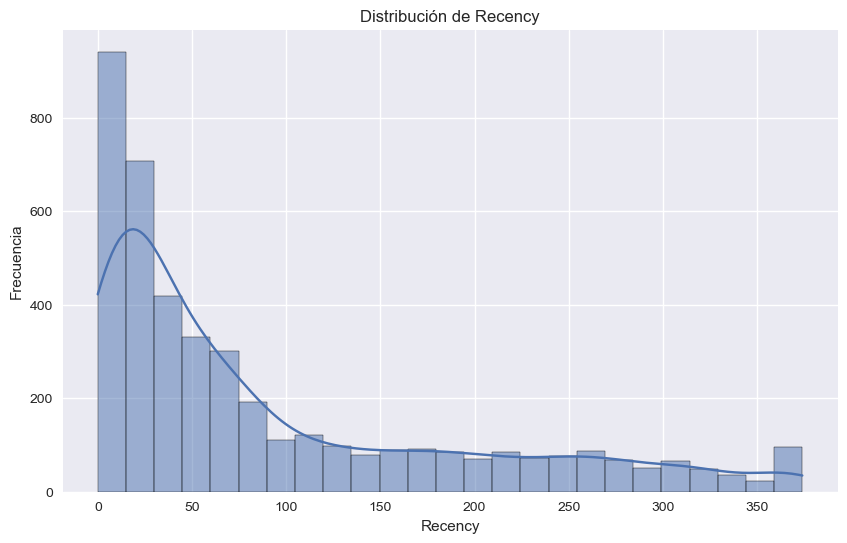

/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


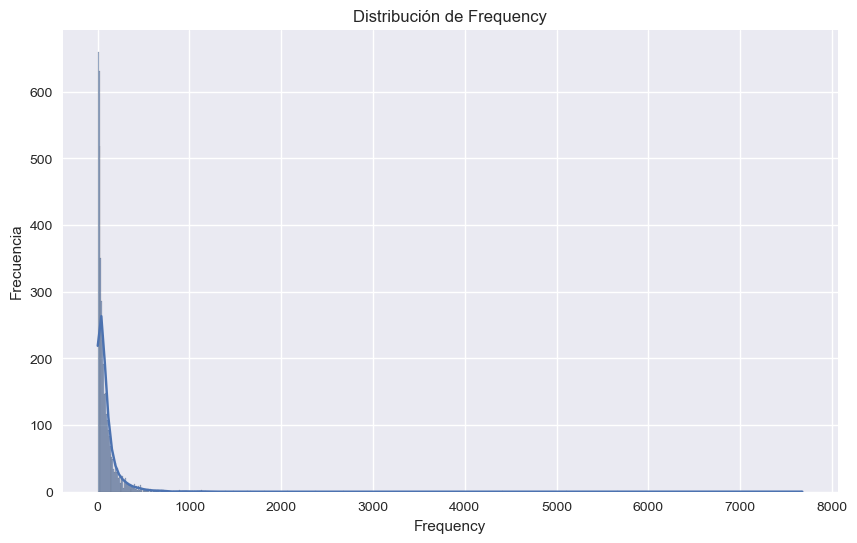

/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


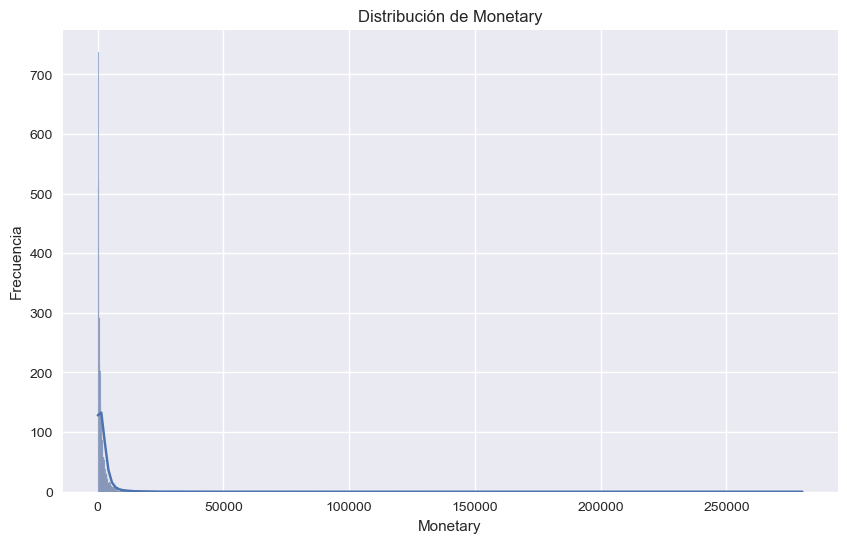

In [17]:
# Configurar el estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
# Función para crear histogramas
def plot_distribution(dataframe, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataframe, x=column, kde=True)
    plt.title(f'Distribución de {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frecuencia')
    plt.show()

# Crear histogramas para cada métrica RFM
for column in ['recency', 'frequency', 'monetary']:
    plot_distribution(rfm, column)

- Distribución de Recency:

La gráfica muestra una distribución asimétrica positiva (cola hacia la derecha).
Hay una alta concentración de clientes con recency baja (cerca de 0), lo que indica que muchos clientes han realizado compras recientemente.
Hay una cola larga hacia la derecha, lo que sugiere que algunos clientes no han comprado en mucho tiempo.

- Distribución de Frequency:

Muestra una distribución extremadamente asimétrica positiva (cola larga a la derecha).
La gran mayoría de los clientes tienen una frecuencia de compra baja (cerca de 0).
Hay unos pocos clientes con frecuencias de compra muy altas (hasta 7000+).


- Distribución de Monetary:

También presenta una distribución muy asimétrica positiva.
La mayoría de los clientes tienen un valor monetario bajo.
Hay algunos clientes con valores monetarios extremadamente altos (hasta 250,000+).

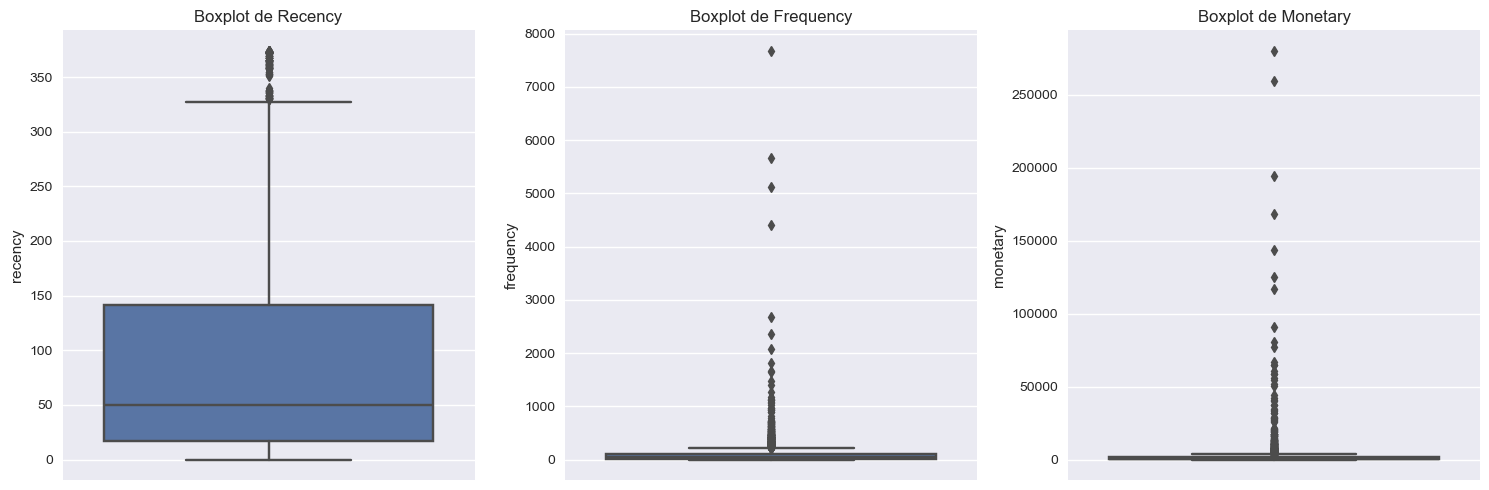

In [19]:
# Boxplots para cada métrica RFM
plt.figure(figsize=(15, 5))
for i, column in enumerate(['recency', 'frequency', 'monetary'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=rfm[column])
    plt.title(f'Boxplot de {column.capitalize()}')
plt.tight_layout()
plt.show()

In [20]:
# Para cada métrica RFM
for column in ['recency', 'frequency', 'monetary']:
    print(f"\nEstadísticas para {column.capitalize()}:")
    stats = rfm[column].describe(percentiles=[.25, .5, .75])
    print(stats)
    
    # Cálculo del IQR y límites para outliers
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"Límite inferior para outliers: {lower_bound}")
    print(f"Límite superior para outliers: {upper_bound}")
    print(f"Número de outliers inferiores: {sum(rfm[column] < lower_bound)}")
    print(f"Número de outliers superiores: {sum(rfm[column] > upper_bound)}")


Estadísticas para Recency:
count    4338.000000
mean       91.610650
std       100.191727
min         0.000000
25%        17.000000
50%        50.000000
75%       141.000000
max       374.000000
Name: recency, dtype: float64
Límite inferior para outliers: -169.0
Límite superior para outliers: 327.0
Número de outliers inferiores: 0
Número de outliers superiores: 155

Estadísticas para Frequency:
count    4338.000000
mean       90.523744
std       225.506968
min         1.000000
25%        17.000000
50%        41.000000
75%        98.000000
max      7676.000000
Name: frequency, dtype: float64
Límite inferior para outliers: -104.5
Límite superior para outliers: 219.5
Número de outliers inferiores: 0
Número de outliers superiores: 381

Estadísticas para Monetary:
count      4338.000000
mean       2048.688081
std        8985.230220
min           3.750000
25%         306.482500
50%         668.570000
75%        1660.597500
max      280206.020000
Name: monetary, dtype: float64
Límite inferio

Gracias por proporcionar estos datos detallados. Vamos a analizarlos para cada métrica RFM:

## Recency:
   - La recencia media es de 91.61 días, con una mediana de 50 días.
   - El 75% de los clientes han comprado en los últimos 141 días.
   - Hay 155 clientes (3.57%) considerados outliers superiores, que no han comprado en más de 327 días.
   - La distribución es asimétrica positiva (media > mediana), lo que indica una cola larga hacia la derecha.

## Frequency:
   - La frecuencia media de compra es 90.52, pero la mediana es solo 41, indicando una fuerte asimetría positiva.
   - El 75% de los clientes han realizado 98 o menos compras.
   - Hay 381 clientes (8.78%) considerados outliers superiores, con más de 219.5 compras.
   - El máximo de 7676 compras sugiere la presencia de algunos clientes extremadamente frecuentes.

## Monetary:
   - El valor monetario medio es de 2048.69, pero la mediana es solo 668.57, indicando una fuerte asimetría positiva.
   - El 75% de los clientes han gastado 1660.60 o menos.
   - Hay 425 clientes (9.80%) considerados outliers superiores, gastando más de 3691.77.
   - El máximo de 280,206.02 sugiere la presencia de algunos clientes de muy alto valor.

## Conclusiones y recomendaciones:

- Asimetría: Todas las métricas muestran una fuerte asimetría positiva, especialmente Frequency y Monetary. Esto refuerza la necesidad de una transformación logarítmica antes del clustering.

- **Outliers**: Hay un número significativo de outliers superiores en todas las métricas, especialmente en Frequency y Monetary. Estos representan clientes de alto valor que merecen un análisis y tratamiento especial.

- Segmentación: La gran diferencia entre la media y la mediana en Frequency y Monetary sugiere que una pequeña proporción de clientes contribuye significativamente al negocio. Una segmentación efectiva podría ayudar a identificar y manejar estos grupos de manera diferenciada.

- Estrategias diferenciadas:
   - Para clientes con alta recencia (>327 días), considerar campañas de reactivación.
   - Para los outliers superiores en Frequency y Monetary, desarrollar programas de fidelización y retención especiales.
   - Para la mayoría de los clientes (que están por debajo de la mediana en Frequency y Monetary), diseñar estrategias para aumentar su frecuencia de compra y valor.

- Preparación para clustering:
   - Aplicar transformación logarítmica a Frequency y Monetary.
   - Normalizar todas las variables.
   - Al interpretar los resultados del clustering, prestar especial atención a cómo se agrupan los outliers.


Outliers en recency:
Número de outliers: 155
Límite inferior: -169.0
Límite superior: 327.0
             recency  frequency  monetary
customer_id                              
12386            338         10    401.90
12441            367         11    173.55
12489            336         15    334.93
12501            337        149   2169.39
12515            353         16    383.70

Outliers en frequency:
Número de outliers: 381
Límite inferior: -104.5
Límite superior: 219.5
             recency  frequency   monetary
customer_id                               
12359             57        245    6310.03
12362              2        266    5226.23
12415             23        714  124914.53
12428             25        294    7956.46
12431             35        234    6419.95

Outliers en monetary:
Número de outliers: 425
Límite inferior: -1724.6899999999996
Límite superior: 3691.7699999999995
             recency  frequency  monetary
customer_id                              
12346        

/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


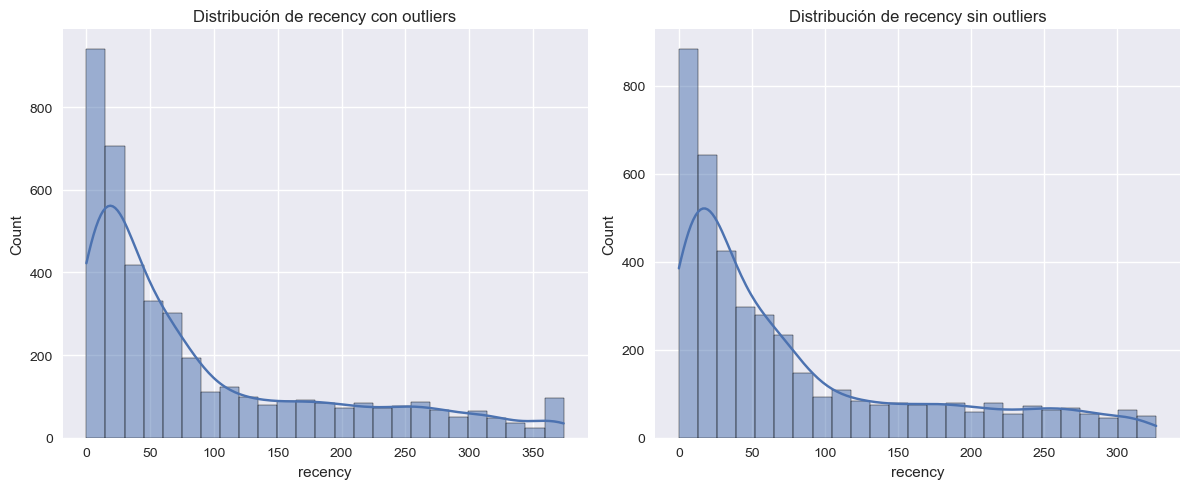

/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


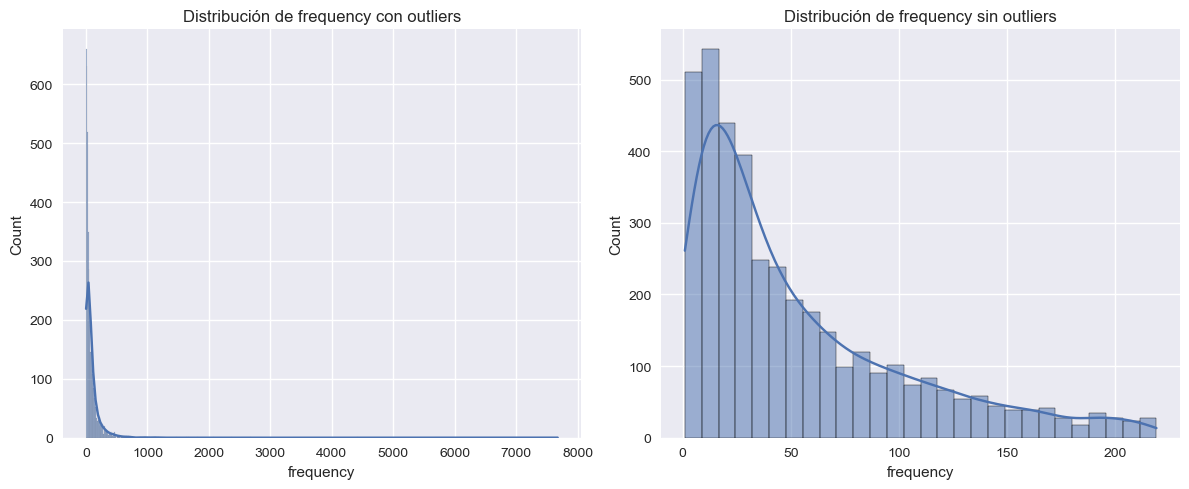

/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


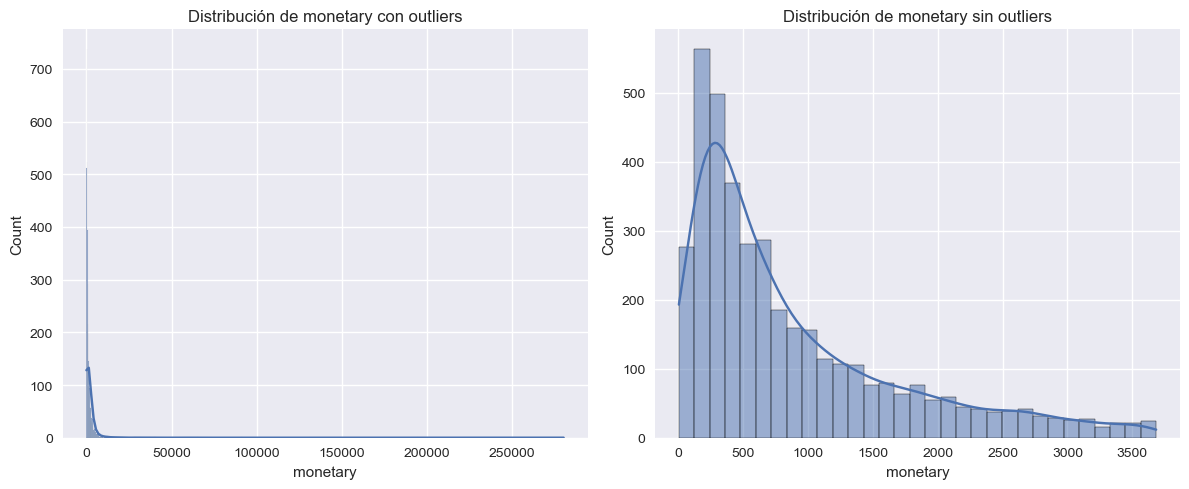

In [22]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for column in ['recency', 'frequency', 'monetary']:
    outliers, lower, upper = identify_outliers(rfm, column)
    print(f"\nOutliers en {column}:")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Límite inferior: {lower}")
    print(f"Límite superior: {upper}")
    print(outliers.head())


def extreme_outliers(df, column, factor=3):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    extremes = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return extremes

for column in ['recency', 'frequency', 'monetary']:
    extremes = extreme_outliers(rfm, column)
    print(f"\nOutliers extremos en {column}:")
    print(f"Número de outliers extremos: {len(extremes)}")
    print(extremes.head())

def plot_distribution_with_without_outliers(df, column):
    outliers, lower, upper = identify_outliers(df, column)
    non_outliers = df[(df[column] >= lower) & (df[column] <= upper)]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribución de {column} con outliers')
    
    plt.subplot(122)
    sns.histplot(non_outliers[column], kde=True)
    plt.title(f'Distribución de {column} sin outliers')
    
    plt.tight_layout()
    plt.show()

for column in ['recency', 'frequency', 'monetary']:
    plot_distribution_with_without_outliers(rfm, column)

### Distribuciones sin Outliers en Frequency y Monetary

Tamaño del DataFrame rfm actualizado: 3662

Estadísticas descriptivas del rfm actualizado:
           recency    frequency     monetary
count  3662.000000  3662.000000  3662.000000
mean    103.790279    45.593119   796.690121
std     103.034756    40.241099   750.029262
min       0.000000     1.000000     3.750000
25%      23.000000    15.000000   261.975000
50%      63.000000    31.000000   528.885000
75%     169.000000    66.000000  1071.375000
max     374.000000   172.000000  3683.860000


/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


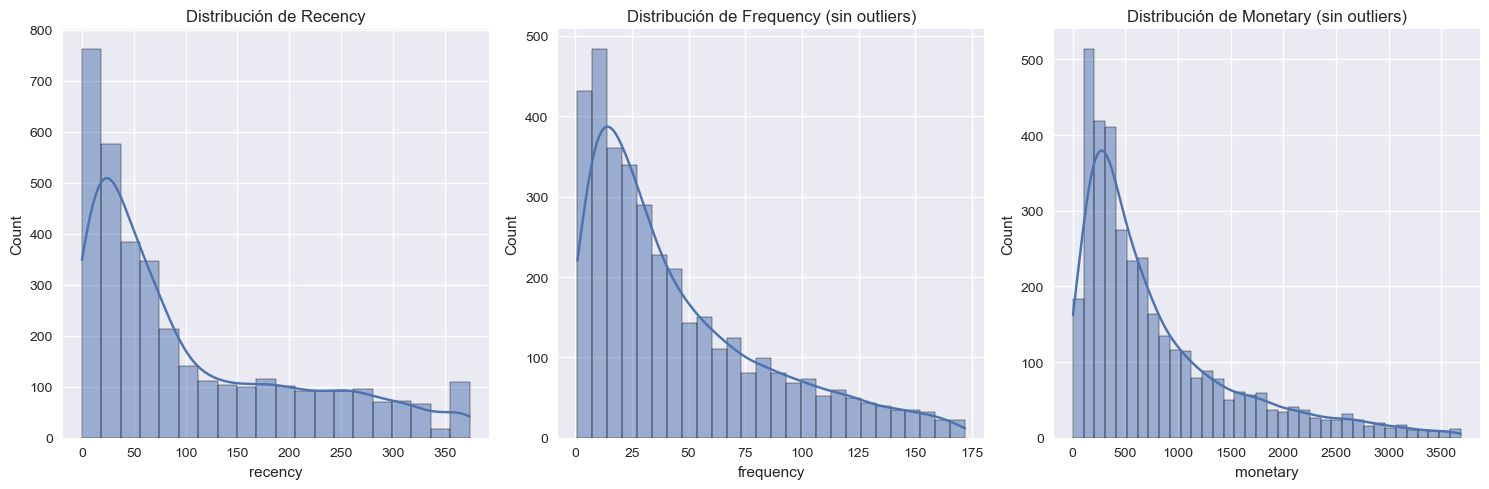

In [24]:
# Función para remover outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

# Actualizar rfm eliminando outliers de 'monetary' y 'frequency'
rfm = remove_outliers(rfm, ['monetary', 'frequency'])

# Imprimir información sobre el nuevo DataFrame
print(f"Tamaño del DataFrame rfm actualizado: {len(rfm)}")
print("\nEstadísticas descriptivas del rfm actualizado:")
print(rfm.describe())

plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(data=rfm, x='recency', kde=True)
plt.title('Distribución de Recency')

plt.subplot(132)
sns.histplot(data=rfm, x='frequency', kde=True)
plt.title('Distribución de Frequency (sin outliers)')

plt.subplot(133)
sns.histplot(data=rfm, x='monetary', kde=True)
plt.title('Distribución de Monetary (sin outliers)')

plt.tight_layout()
plt.show()

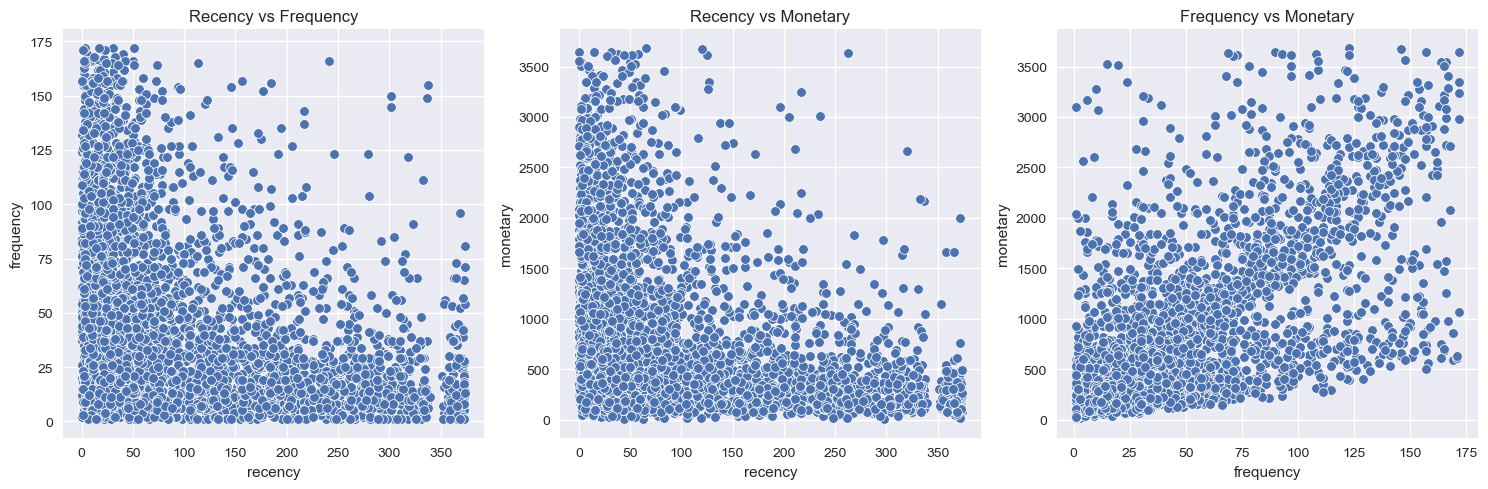

In [25]:
# Scatter plots para visualizar relaciones entre métricas
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.scatterplot(data=rfm, x='recency', y='frequency')
plt.title('Recency vs Frequency')
plt.subplot(132)
sns.scatterplot(data=rfm, x='recency', y='monetary')
plt.title('Recency vs Monetary')
plt.subplot(133)
sns.scatterplot(data=rfm, x='frequency', y='monetary')
plt.title('Frequency vs Monetary')
plt.tight_layout()
plt.show()

- Recency vs Frequency: Muestra una concentración de puntos en la esquina inferior izquierda, indicando que muchos clientes tienen baja recencia y baja frecuencia. Hay algunos outliers con frecuencia muy alta.
- Recency vs Monetary: Similar al anterior, con la mayoría de los puntos concentrados en valores bajos, pero con algunos outliers de alto valor monetario.
- Frequency vs Monetary: Muestra una relación positiva más clara, con algunos clientes destacando por tener valores muy altos en ambas métricas.

Matriz de correlación:
            recency  frequency  monetary
recency    1.000000  -0.351372 -0.327549
frequency -0.351372   1.000000  0.673326
monetary  -0.327549   0.673326  1.000000


Relación entre Recency y Frequency:
Correlación: -0.3514
Covarianza: -1456.8712
Recency - Media: 103.7903, Desviación estándar: 103.0348
Frequency - Media: 45.5931, Desviación estándar: 40.2411


Relación entre Recency y Monetary:
Correlación: -0.3275
Covarianza: -25312.6626
Recency - Media: 103.7903, Desviación estándar: 103.0348
Monetary - Media: 796.6901, Desviación estándar: 750.0293


Relación entre Frequency y Monetary:
Correlación: 0.6733
Covarianza: 20322.3175
Frequency - Media: 45.5931, Desviación estándar: 40.2411
Monetary - Media: 796.6901, Desviación estándar: 750.0293




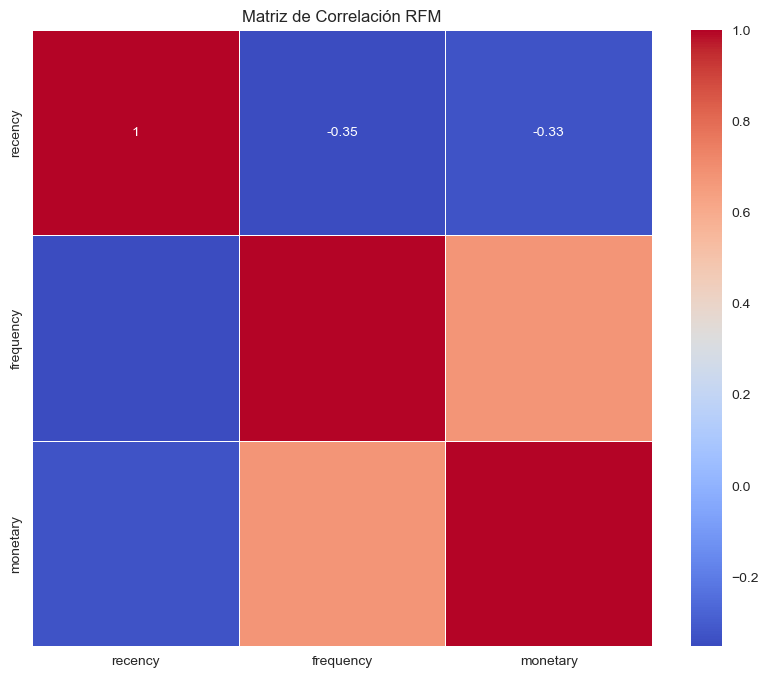

In [27]:
# Calcular la matriz de correlación
corr_matrix = rfm[['recency', 'frequency', 'monetary']].corr()

print("Matriz de correlación:")
print(corr_matrix)
print("\n")

# Función para describir la relación entre dos variables
def describe_relationship(x, y, x_name, y_name):
    print(f"Relación entre {x_name} y {y_name}:")
    print(f"Correlación: {x.corr(y):.4f}")
    print(f"Covarianza: {x.cov(y):.4f}")
    print(f"{x_name} - Media: {x.mean():.4f}, Desviación estándar: {x.std():.4f}")
    print(f"{y_name} - Media: {y.mean():.4f}, Desviación estándar: {y.std():.4f}")
    print("\n")

# Describir las relaciones
describe_relationship(rfm['recency'], rfm['frequency'], 'Recency', 'Frequency')
describe_relationship(rfm['recency'], rfm['monetary'], 'Recency', 'Monetary')
describe_relationship(rfm['frequency'], rfm['monetary'], 'Frequency', 'Monetary')

# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación RFM')
plt.show()

Recency y Frequency: 
- -La correlación entre Recency y Frequency es negativa (-0.3514), lo que indica que a medida que la Recency aumenta, la Frequency tiende a disminuir, y viceversa. Esto podría sugerir que los clientes que han comprado más recientemente tienden a hacer compras con menos frecuencia.

Recency y Monetary: 
- La correlación entre Recency y Monetary también es negativa (-0.3275), lo que sugiere que los clientes que han comprado más recientemente tienden a gastar menos, y viceversa. Esto podría indicar que los clientes que gastan más tienden a hacerlo en compras menos frecuentes.

- Frequency y Monetary: La correlación entre Frequency y Monetary es positiva (0.6733), lo que indica que a medida que la Frequency aumenta, la Monetary también tiende a aumentar. Esto sugiere que los clientes que hacen compras con más frecuencia también tienden a gastar más en total.

Estas son solo observaciones generales y podrían no aplicarse a todos los clientes. También es importante tener en cuenta otros factores que podrían influir en estas relaciones.

In [29]:
# Estadísticas descriptivas
print(rfm.describe())

# Asimetría y curtosis
print("\nAsimetría:")
print(rfm.skew())
print("\nCurtosis:")
print(rfm.kurtosis())

           recency    frequency     monetary
count  3662.000000  3662.000000  3662.000000
mean    103.790279    45.593119   796.690121
std     103.034756    40.241099   750.029262
min       0.000000     1.000000     3.750000
25%      23.000000    15.000000   261.975000
50%      63.000000    31.000000   528.885000
75%     169.000000    66.000000  1071.375000
max     374.000000   172.000000  3683.860000

Asimetría:
recency      1.063685
frequency    1.153950
monetary     1.553947
dtype: float64

Curtosis:
recency     -0.037111
frequency    0.531266
monetary     1.989756
dtype: float64


- La asimetría es una medida de la falta de simetría en la distribución de los datos. Un valor de asimetría **positivo** indica una distribución con cola a la derecha o sesgada a la derecha.

- La curtosis es una medida de la **pesadez** de las colas de una distribución. En comparación con una distribución normal, un valor de curtosis positivo indica colas más pesadas (más propensas a tener valores extremos), mientras que un valor negativo indica colas más ligeras (menos propensas a tener valores extremos).

### Segmentación de clientes (Clustering)

In [32]:
# Aplicar transformación logarítmica
rfm['log_frequency'] = np.log1p(rfm['frequency'])
rfm['log_monetary'] = np.log1p(rfm['monetary'])

In [33]:
# Crear un nuevo DataFrame con las variables transformadas
rfm_normalized = rfm[['recency', 'log_frequency', 'log_monetary']].copy()

# Normalizar las variables
scaler = StandardScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_normalized), 
                              columns=['recency', 'log_frequency', 'log_monetary'], 
                              index=rfm.index)

/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

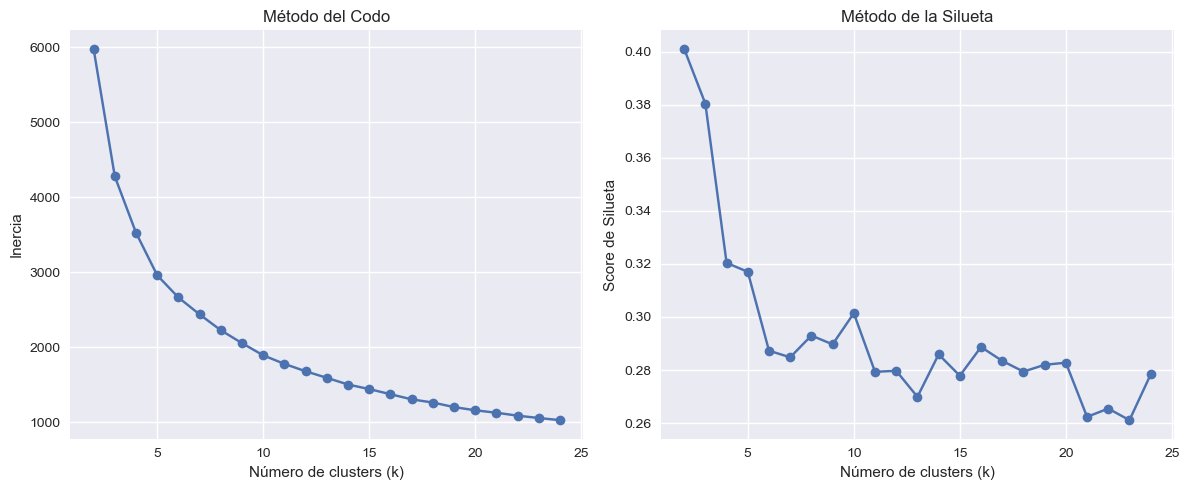

In [34]:
# Función para calcular la inercia (suma de las distancias al cuadrado)
def calculate_inertia(data, k_range):
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    return inertias

# Función para calcular el score de silueta
def calculate_silhouette(data, k_range):
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    return silhouette_scores

# Rango de número de clusters a probar
k_range = range(2, 25)

# Calcular inercia y score de silueta
inertias = calculate_inertia(rfm_normalized, k_range)
silhouette_scores = calculate_silhouette(rfm_normalized, k_range)

# Visualizar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(122)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Score de Silueta')
plt.title('Método de la Silueta')

plt.tight_layout()
plt.show()

- Número óptimo de clusters:
El gráfico del método del codo muestra una disminución pronunciada de la inercia hasta aproximadamente 4-5 clusters, después de lo cual la disminución se vuelve más gradual. El gráfico del score de silueta muestra valores más altos para números menores de clusters, con un pico local alrededor de 4-5 clusters. El código establece optimal_k = 4, lo cual concuerda con estas observaciones.

In [36]:
# Supongamos que el número óptimo de clusters es 5 (ajusta según tus resultados)
optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Añadir los clusters al DataFrame original
rfm_with_clusters = rfm.copy()
rfm_with_clusters['Cluster'] = rfm['Cluster']

/Users/claudio.merino/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Estadísticas por cluster:
            recency  frequency     monetary  count
Cluster                                           
0        240.772313  36.134791   563.934827    549
1        278.420792   8.497525   191.928688    404
2         67.638047  10.533670   226.333771    594
3         48.617121  36.756350   601.511207   1063
4         41.403992  93.500000  1669.668385   1052


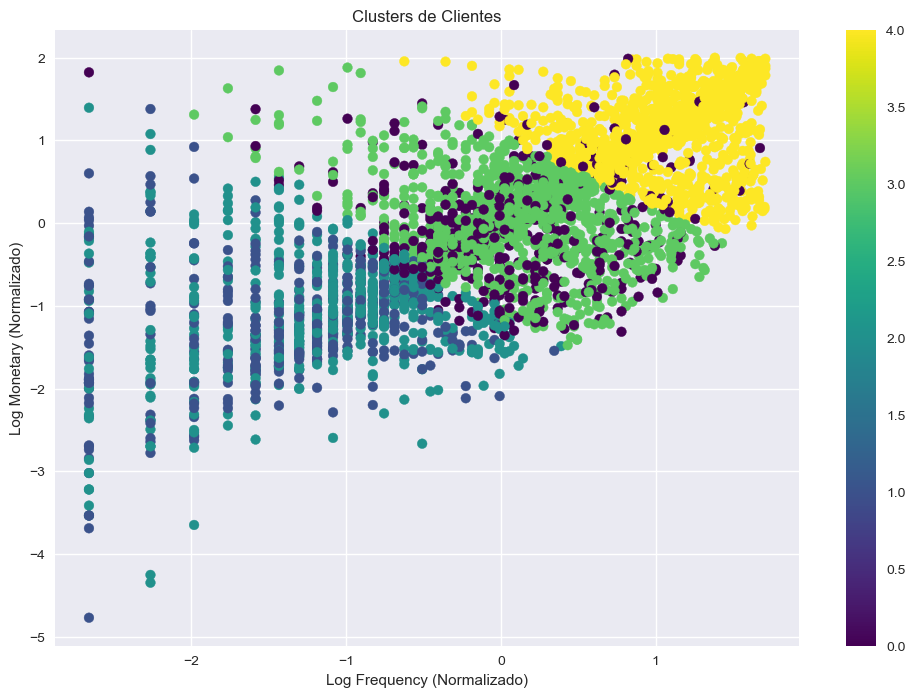

In [37]:
# Estadísticas descriptivas por cluster
cluster_stats = rfm_with_clusters.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
})

# Añadir el conteo de clientes por cluster
cluster_stats['count'] = rfm_with_clusters.groupby('Cluster').size()

print("Estadísticas por cluster:")
print(cluster_stats)

# Visualizar los clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(rfm_normalized['log_frequency'], 
                      rfm_normalized['log_monetary'], 
                      c=rfm['Cluster'], 
                      cmap='viridis')
plt.xlabel('Log Frequency (Normalizado)')
plt.ylabel('Log Monetary (Normalizado)')
plt.title('Clusters de Clientes')
plt.colorbar(scatter)
plt.show()

### Clientes de alto valor (Cluster 4):
- **Estrategia**: Programas de fidelización, ofertas exclusivas, servicio premium.
- **Objetivo**: Mantener su alta frecuencia de compra y aumentar el valor por compra.

### Clientes activos de valor medio (Cluster 3):
- **Estrategia**: Incentivos para aumentar el valor de compra, cross-selling.
- **Objetivo**: Incrementar el valor monetario de sus compras.

### Clientes recientes de bajo valor (Cluster 2):
- **Estrategia**: Campañas para aumentar la frecuencia de compra, ofertas atractivas.
- **Objetivo**: Convertirlos en clientes más frecuentes y de mayor valor.

### Clientes de valor medio con baja recencia (Cluster 0):
- **Estrategia**: Campañas de reactivación, ofertas personalizadas basadas en compras anteriores.
- **Objetivo**: Reducir el tiempo desde la última compra y aumentar la frecuencia.

### Clientes inactivos de bajo valor (Cluster 1):
- **Estrategia**: Campañas de reactivación agresivas, encuestas para entender la inactividad.
- **Objetivo**: Recuperar estos clientes o decidir si vale la pena invertir en ellos.

**Observaciones generales:**

Los clusters 3 y 4 (clientes activos y de alto valor) representan la mayor parte de la base de clientes (2115 de 3662, o 57.8%).
Hay una clara diferenciación entre los segmentos en términos de comportamiento de compra.
La recencia parece ser un factor importante en la segmentación, con una clara distinción entre clientes activos e inactivos.

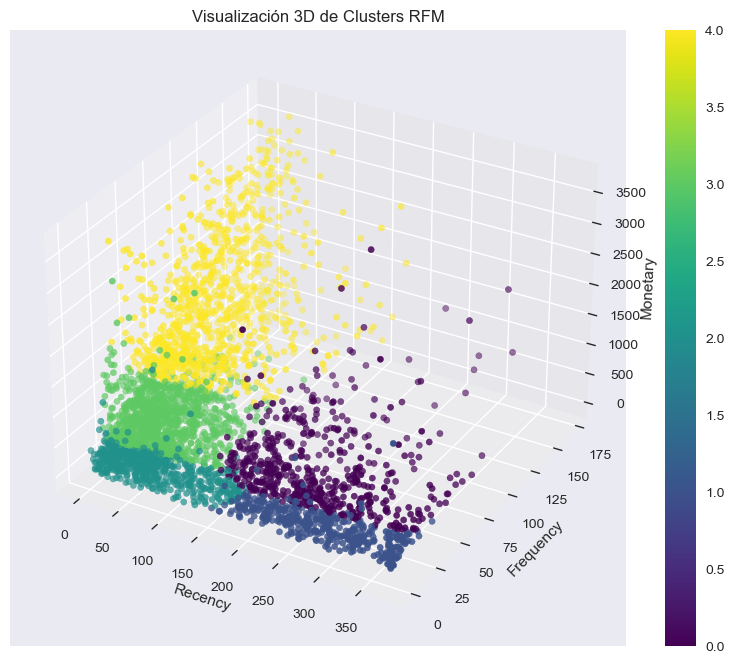

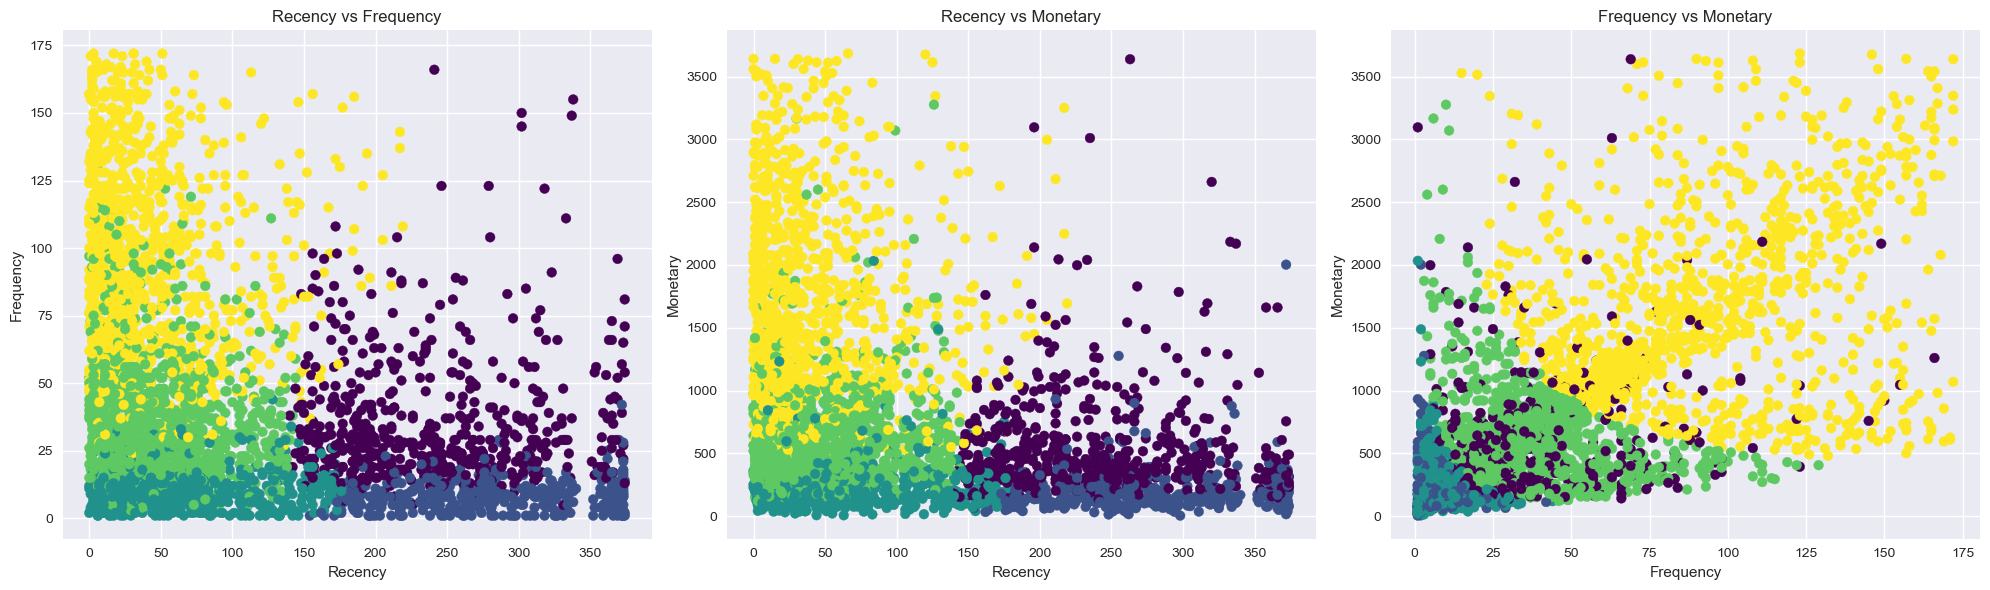

In [39]:
# Gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'], 
                     c=rfm['Cluster'], cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Visualización 3D de Clusters RFM')
plt.colorbar(scatter)
plt.show()

# Gráficos 2D
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].scatter(rfm['recency'], rfm['frequency'], c=rfm['Cluster'], cmap='viridis')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')

axes[1].scatter(rfm['recency'], rfm['monetary'], c=rfm['Cluster'], cmap='viridis')
axes[1].set_xlabel('Recency')
axes[1].set_ylabel('Monetary')
axes[1].set_title('Recency vs Monetary')

axes[2].scatter(rfm['frequency'], rfm['monetary'], c=rfm['Cluster'], cmap='viridis')
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary')
axes[2].set_title('Frequency vs Monetary')

plt.tight_layout()
plt.show()

In [40]:
# Asumiendo que tenemos información adicional como 'product_category' y 'purchase_month'
for cluster in rfm['Cluster'].unique():
    cluster_data = rfm[rfm['Cluster'] == cluster]
    
    print(f"\nAnálisis detallado del Cluster {cluster}:")
    print(f"Número de clientes: {len(cluster_data)}")
    print("\nEstadísticas RFM:")
    print(cluster_data[['recency', 'frequency', 'monetary']].describe())
    
    # Análisis de productos (si está disponible)
    if 'product_category' in rfm.columns:
        print("\nTop 5 categorías de productos:")
        print(cluster_data['product_category'].value_counts().head())
    
    # Análisis de estacionalidad (si está disponible)
    if 'purchase_month' in rfm.columns:
        print("\nDistribución de compras por mes:")
        print(cluster_data['purchase_month'].value_counts().sort_index())
    
    print("\n" + "="*50)


Análisis detallado del Cluster 4:
Número de clientes: 1052

Estadísticas RFM:
           recency    frequency     monetary
count  1052.000000  1052.000000  1052.000000
mean     41.403992    93.500000  1669.668385
std      41.353910    35.588875   753.294216
min       0.000000    15.000000   480.380000
25%      11.000000    65.000000  1070.950000
50%      28.000000    89.000000  1531.095000
75%      58.000000   120.000000  2158.810000
max     219.000000   172.000000  3683.860000


Análisis detallado del Cluster 0:
Número de clientes: 549

Estadísticas RFM:
          recency   frequency     monetary
count  549.000000  549.000000   549.000000
mean   240.772313   36.134791   563.934827
std     61.737562   24.019458   415.486268
min    140.000000    1.000000   135.190000
25%    189.000000   20.000000   315.060000
50%    235.000000   29.000000   429.600000
75%    288.000000   44.000000   641.920000
max    374.000000  166.000000  3638.410000


Análisis detallado del Cluster 1:
Número de clie

Claro, aquí tienes la información en formato Markdown:

# Análisis de Clusters RFM

## Resumen de Clusters

| Cluster | Nombre | Recencia (días) | Frecuencia | Monetario ($) | Clientes |
|---------|--------|-----------------|------------|---------------|----------|
| 4 | Clientes de alto valor | 41 | 93.5 | 1,669 | 1,052 |
| 3 | Clientes activos de valor medio | 48 | 36.7 | 601 | 1,063 |
| 2 | Clientes recientes de bajo valor | 67 | 10.5 | 226 | 594 |
| 0 | Clientes de valor medio con baja recencia | 240 | 36.1 | 563 | 549 |
| 1 | Clientes inactivos de bajo valor | 278 | 8.5 | 191 | 404 |

## Análisis Detallado por Cluster

### Cluster 4: Clientes de alto valor
- **Características**: Muy activos, alta frecuencia, alto valor
- **Estrategia**: Retención y maximización de valor
- **Acciones**:
  1. Implementar programa VIP exclusivo
  2. Ofrecer acceso anticipado a nuevos productos
  3. Proporcionar servicio al cliente dedicado

### Cluster 3: Clientes activos de valor medio
- **Características**: Activos, frecuencia media, valor medio
- **Estrategia**: Incremento de valor por compra
- **Acciones**:
  1. Crear programa de escalado de compras
  2. Ofrecer paquetes de productos para aumentar el valor por transacción
  3. Desarrollar contenido educativo sobre productos premium

### Cluster 2: Clientes recientes de bajo valor
- **Características**: Recientes, baja frecuencia, bajo valor
- **Estrategia**: Aumento de frecuencia y valor
- **Acciones**:
  1. Lanzar campaña de "segunda compra" con incentivos
  2. Implementar sistema de recomendaciones personalizadas
  3. Introducir programa de fidelización básico

### Cluster 0: Clientes de valor medio con baja recencia
- **Características**: Baja recencia, frecuencia media, valor medio
- **Estrategia**: Reactivación personalizada
- **Acciones**:
  1. Desarrollar campaña "te extrañamos" con ofertas especiales
  2. Enviar recordatorios de productos previamente comprados
  3. Realizar encuesta para entender razones de inactividad

### Cluster 1: Clientes inactivos de bajo valor
- **Características**: Muy baja recencia, baja frecuencia, bajo valor
- **Estrategia**: Recuperación y reactivación
- **Acciones**:
  1. Lanzar campaña de "última oportunidad" con descuentos significativos
  2. Implementar programa de reactivación por etapas
  3. Evaluar ROI de marketing para este grupo

## Próximos Pasos

1. Implementar sistema de puntuación RFM continuo
2. Desarrollar campañas de marketing específicas por cluster
3. Establecer KPIs para medir éxito de estrategias
4. Realizar análisis de cohortes para seguimiento de evolución de clientes
5. Incorporar datos adicionales para segmentación más precisa

## Observaciones Finales de la Segmentación

- Clara segmentación en términos de valor y actividad del cliente
- Clusters 3 y 4 representan la mayoría de la base de clientes
- Oportunidad de mover clientes entre clusters adyacentes
- Urgencia en estrategias de reactivación para clusters 0 y 1

## Entrenamiento y pruebas de modelos

Tabla de Métricas (en porcentaje):
                      Precisión  Sensibilidad  F1-Score  Accuracy  AUC-ROC
SVM                       83.38         82.37     82.78     84.04    97.29
KNN                       88.70         87.46     87.95     88.68    97.52
Árbol de Decisión         95.98         95.43     95.67     95.50    97.13
Gradient Boosting         96.95         96.55     96.72     96.73    99.89
Naive Bayes               91.88         92.87     92.30     92.36    99.19
Ensamble de Votación      96.07         95.43     95.72     95.50    99.79
MLP                       93.50         92.69     92.88     92.63    99.54
Random Forest             97.41         97.30     97.34     97.27    99.94




/var/folders/0v/9zjz6_3d4d31031nj12myf840000gn/T/ipykernel_76002/3789566307.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(modelos_nombres, rotation=45, ha='right')
/var/folders/0v/9zjz6_3d4d31031nj12myf840000gn/T/ipykernel_76002/3789566307.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(modelos_nombres, rotation=45, ha='right')
/var/folders/0v/9zjz6_3d4d31031nj12myf840000gn/T/ipykernel_76002/3789566307.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(modelos_nombres, rotation=45, ha='right')
/var/folders/0v/9zjz6_3d4d31031nj12myf840000gn/T/ipykernel_76002/3789566307.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

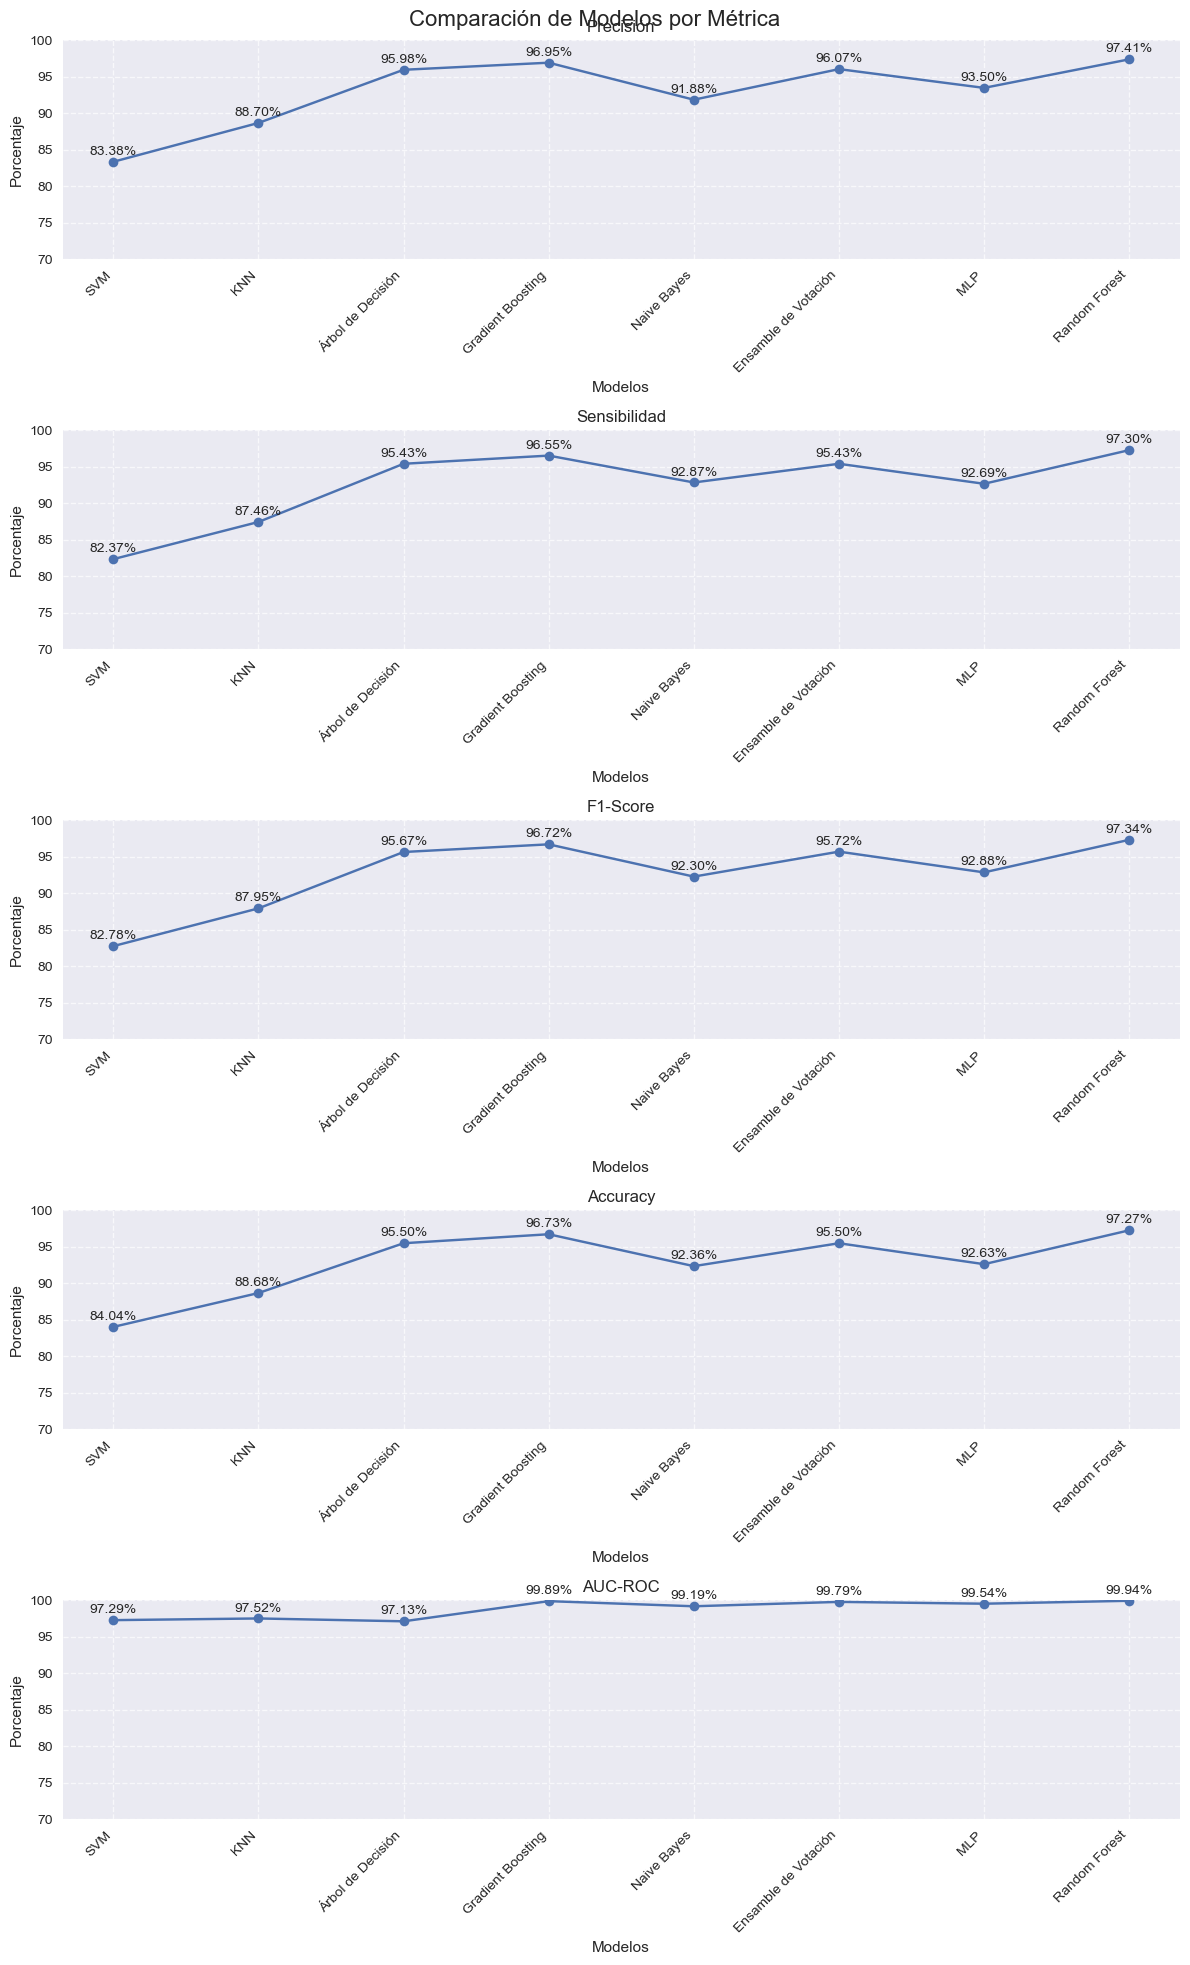

Nota: La curva ROC no se muestra para problemas multiclase.


In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

def comparar_modelos_visualmente(modelos, X_test, y_test):
    metricas = {}
    n_classes = len(np.unique(y_test))
    is_binary = n_classes == 2
    
    for nombre, modelo in modelos.items():
        y_pred = modelo.predict(X_test)
        if is_binary:
            y_prob = modelo.predict_proba(X_test)[:, 1]
        else:
            y_prob = modelo.predict_proba(X_test)
        
        metricas[nombre] = {
            'Precisión': precision_score(y_test, y_pred, average='macro'),
            'Sensibilidad': recall_score(y_test, y_pred, average='macro'),
            'F1-Score': f1_score(y_test, y_pred, average='macro'),
            'Accuracy': accuracy_score(y_test, y_pred),
        }
        
        if is_binary:
            metricas[nombre]['AUC-ROC'] = roc_auc_score(y_test, y_prob)
        else:
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            metricas[nombre]['AUC-ROC'] = roc_auc_score(y_test_bin, y_prob, multi_class='ovr', average='macro')
    
    # Crear tabla de métricas
    df_metricas = pd.DataFrame(metricas).T * 100  # Convertir a porcentaje
    df_metricas = df_metricas.round(2)  # Redondear a 2 decimales
    print("Tabla de Métricas (en porcentaje):")
    print(df_metricas.to_string())
    print("\n")
    
    # Crear un gráfico de líneas para cada métrica
    metricas_nombres = ['Precisión', 'Sensibilidad', 'F1-Score', 'Accuracy', 'AUC-ROC']
    modelos_nombres = list(metricas.keys())
    
    fig, axes = plt.subplots(len(metricas_nombres), 1, figsize=(12, 4*len(metricas_nombres)))
    fig.suptitle('Comparación de Modelos por Métrica', fontsize=16)
    
    for i, metrica in enumerate(metricas_nombres):
        valores = df_metricas[metrica].values
        axes[i].plot(modelos_nombres, valores, marker='o')
        axes[i].set_title(metrica)
        axes[i].set_xlabel('Modelos')
        axes[i].set_ylabel('Porcentaje')
        axes[i].set_ylim(70, 100)  # Establecer el rango del eje y de 70% a 100%
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].set_xticklabels(modelos_nombres, rotation=45, ha='right')
        
        # Añadir etiquetas de valor en cada punto
        for j, valor in enumerate(valores):
            axes[i].annotate(f'{valor:.2f}%', (j, valor), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Crear gráfico de curva ROC para todos los modelos (solo para clasificación binaria)
    if is_binary:
        plt.figure(figsize=(10, 8))
        for nombre, modelo in modelos.items():
            y_prob = modelo.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Curva ROC - Comparación de Modelos')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("Nota: La curva ROC no se muestra para problemas multiclase.")

# Uso de la función
modelos = {
    'SVM': svm,
    'KNN': knn,
    'Árbol de Decisión': tree,
    'Gradient Boosting': gb,
    'Naive Bayes': nb,
    'Ensamble de Votación': voting_clf,
    'MLP': mlp,
    'Random Forest': rf
}

comparar_modelos_visualmente(modelos, X_test, y_test)

# Análisis de Rendimiento de Modelos de Clasificación

## Resumen General

Los datos muestran el rendimiento de 8 modelos de clasificación diferentes, evaluados en 5 métricas distintas. Todos los modelos muestran un rendimiento generalmente bueno, con valores superiores al 80% en todas las métricas.

## Análisis por Modelo

### Random Forest
- **Mejor rendimiento general**
- Líder en 4 de 5 métricas (Precisión, F1-Score, Accuracy, AUC-ROC)
- Rendimiento excepcionalmente equilibrado en todas las métricas

### Gradient Boosting
- Segundo mejor rendimiento general
- Muy cercano al Random Forest en todas las métricas
- Destacado en Sensibilidad (96.55%)

### Ensamble de Votación
- Tercer mejor rendimiento
- Muestra la fuerza de combinar múltiples modelos
- Excelente AUC-ROC (99.79%)

### Árbol de Decisión
- Sorprendentemente buen rendimiento para un modelo relativamente simple
- Cuarto en la mayoría de las métricas
- Menor AUC-ROC entre los modelos de alto rendimiento (97.13%)

### MLP (Red Neuronal)
- Rendimiento sólido pero no excepcional
- Consistente en todas las métricas

### Naive Bayes
- Rendimiento sorprendentemente bueno para un modelo tan simple
- Destaca en AUC-ROC (99.19%)

### KNN
- Rendimiento moderado
- Consistente en todas las métricas

### SVM
- Rendimiento más bajo en la mayoría de las métricas
- Aún así, muestra un buen AUC-ROC (97.29%)

## Análisis por Métrica

1. **Precisión**: Random Forest lidera (97.41%), seguido de cerca por Gradient Boosting (96.95%).
2. **Sensibilidad**: Random Forest nuevamente en la cima (97.30%), con Gradient Boosting muy cerca (96.55%).
3. **F1-Score**: Random Forest mantiene el liderazgo (97.34%), seguido por Gradient Boosting (96.72%).
4. **Accuracy**: Random Forest continúa dominando (97.27%), con Gradient Boosting en segundo lugar (96.73%).
5. **AUC-ROC**: Todos los modelos muestran un excelente rendimiento, con Random Forest liderando (99.94%), seguido muy de cerca por Gradient Boosting (99.89%) y Ensamble de Votación (99.79%).

## Conclusiones

1. **Random Forest** se destaca como el mejor modelo general, liderando en todas las métricas.
2. **Gradient Boosting** es un fuerte competidor, muy cerca del rendimiento de Random Forest.
3. Los modelos de **ensemble** (Random Forest, Gradient Boosting, Ensamble de Votación) muestran un rendimiento superior, lo que sugiere que la combinación de múltiples modelos es efectiva para este conjunto de datos.
4. Incluso los modelos más simples como **Árbol de Decisión** y **Naive Bayes** muestran un rendimiento sorprendentemente bueno.
5. El alto rendimiento en **AUC-ROC** para todos los modelos sugiere que son capaces de distinguir bien entre las clases, independientemente del umbral de clasificación elegido.

## Recomendaciones

1. **Utilizar Random Forest** como modelo principal debido a su rendimiento superior y consistente.
2. Considerar **Gradient Boosting** como una alternativa sólida o para un ensemble más amplio.
3. Si la velocidad de inferencia o la interpretabilidad son importantes, el **Árbol de Decisión** podría ser una opción viable dado su buen rendimiento.
4. Para aplicaciones que requieran un balance entre rendimiento y simplicidad, **Naive Bayes** podría ser una opción sorprendentemente efectiva.
5. Realizar un análisis de las características más importantes utilizadas por Random Forest y Gradient Boosting para obtener insights sobre el problema de clasificación.